In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals # this is explained here -> 'https://stackoverflow.com/questions/7075082/what-is-future-in-python-used-for-and-how-when-to-use-it-and-how-it-works'

In [2]:
import tensorflow as tf
from tensorflow.keras import optimizers
tf.enable_eager_execution()

In [3]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl # basically used to customize the displays, this link explains it well -> 'https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html'
mpl.rcParams['figure.figsize'] = (15,15)
mpl.rcParams['axes.grid'] = True

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
# Code for displaying the image

In [4]:
def tensor_image(tensor):
    tensor = tensor * 255 # multiply by 255
    tensor = np.array(tensor, dtype = np.uint8) # creating an array of the size of the tensor and a datatype
    if np.ndim(tensor)>3: # this link explains dimensions properly -> 'https://www.mathworks.com/help/matlab/math/multidimensional-arrays.html'
        assert tensor.shape[0] == 1 # this makes sure that the shape[0] dimension is Dimension(1).
        tensor = tensor[0] # this converts the tensor back to 3 dimensions.
    return PIL.Image.fromarray(tensor)

In [5]:
def load_image(image_string):
    max_dim = 512
    image = tf.io.read_file(image_string) # reads in the image and encodes the image.
    image = tf.image.decode_image(image, channels = 3) # checks what type of image it is, Here it is'jpg'. It then converts it to a tensor of dtype
    image = tf.image.convert_image_dtype(image, tf.float32) # converts the image dtype to float32
    
    shape = tf.cast(tf.shape(image)[:-1], tf.float32) # creates a tensor of the same shape and dtype of image
    long_dim = max(shape)
    scale = max_dim/long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32) # here we create another tensor similar to 'shape' but we change the dtype to int 32 and we scale it
    image = tf.image.resize(image, new_shape) # we resize 'image' to have the same size as 'new_shape'
    image = image[tf.newaxis, :] # the concept of tf.newaxis is explained here -> 'https://stackoverflow.com/questions/42344090/what-is-the-alternative-of-numpy-newaxis-in-tensorflow'
    
    return image

In [6]:
def show(image, title = None):
    if len(image.shape)>3:
        image = tf.squeeze(image, axis = 0) # removes a dimension or specified dimension from an image
        
    plt.imshow(image)
    if title:
        plt.title(title)

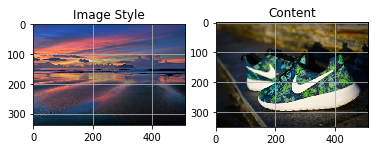

In [7]:
image_style = load_image('skyline.jpg')
content = load_image('nike.jpg')

plt.subplot(1,2,1)
show(image_style,'Image Style')

plt.subplot(1,2,2)
show(content, 'Content')

In [ ]:
# code for predicting the what the image content is.

In [8]:
img =tf.keras.applications.vgg19.preprocess_input(content*255) # Here we preprocess the content image to pass it through the VGG19 CNN.
image = tf.image.resize(img, (224, 224)) # we resize it because the standard input size for  VGG19 model is 224 X 224.

In [9]:
vgg_model = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet') # The VGG19 CNN model.
predictions = vgg_model(image) #passing our image through the model for predictions.
predictions.shape

TensorShape([Dimension(1), Dimension(1000)])

In [10]:
predicted_5 = tf.keras.applications.vgg19.decode_predictions(predictions.numpy())[0] # The [0] is  added to unpack the predictions, without it there would be alot to unpack. 

In [11]:
[(number, class_name, probability) for (number, class_name, probability) in predicted_5]

[('n04120489', 'running_shoe', 0.18586351),
 ('n03047690', 'clog', 0.096156254),
 ('n04200800', 'shoe_shop', 0.06657005),
 ('n04127249', 'safety_pin', 0.054179944),
 ('n04423845', 'thimble', 0.028743088)]

In [ ]:
# accessing the layers used in the vgg19 model

In [12]:
vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # we call the vgg19 model but set the include_top to False i.e we exclude the 3 fully conncected layers

In [13]:
for layer in vgg_model.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [14]:
# THe feature map I used for the content and style layers respectively.
content_layers = ['block5_conv4']

style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2',
                'block4_conv2',
                'block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [15]:
# Building the model

def vgg_layers(layer_name):
    vgg_model = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg_model.trainable = False # we want to freeze the weights, we aren't training the model
    
    outputs = [vgg_model.get_layer(name).output for name in layer_name] # '.get_layer(name).output' This outputs the output of all the specifed layers in the network
    new_model = tf.keras.Model([vgg_model.input], outputs)
    return new_model

#So basically we create a function that takes in the layer names for the style layer, we obtain the outputs for each layer from the
#vgg19 model created, then input the vgg19 model and the outputs into new_model.

                                            
                                            

In [16]:
style_layer_extractor = vgg_layers(style_layers)
style_outputs = style_layer_extractor(image_style * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(' shape : ', output.numpy().shape)
    print(' min : ', output.numpy().min())
    print(' max : ', output.numpy().max())
    print(' mean : ', output.numpy().mean())
    print()

block1_conv2
 shape :  (1, 339, 512, 64)
 min :  0.0
 max :  2374.3608
 mean :  105.87267

block2_conv2
 shape :  (1, 169, 256, 128)
 min :  0.0
 max :  4938.689
 mean :  85.680046

block3_conv2
 shape :  (1, 84, 128, 256)
 min :  0.0
 max :  7636.459
 mean :  122.00438

block4_conv2
 shape :  (1, 42, 64, 512)
 min :  0.0
 max :  15219.191
 mean :  240.34161

block5_conv2
 shape :  (1, 21, 32, 512)
 min :  0.0
 max :  649.7665
 mean :  9.954586



In [17]:
def gram_matrix(input_tensor):
    F_F = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)# this link explains it best 'https://www.tensorflow.org/api_docs/python/tf/einsum?version=stable'
    input_shape = tf.shape(input_tensor)
    I_J = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return F_F/(I_J) # returns the gram matrix equation

In [18]:
class Style_Content_Model(tf.keras.models.Model): # we are inheriting from tf.keras.models.Model
    def __init__(self, style_layers, content_layers):
        super(Style_Content_Model, self).__init__() #  the link provided explains this line of  code properly 'https://realpython.com/python-super/'
        self.vgg_model = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_model.trainable = False
        
        
    def call(self, inputs):
        'expects floats inputs in [0, 1]'
        
        inputs = inputs *255.0
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs) # here we are just preprocessing the inputs
        outputs = self.vgg_model(preprocessed_inputs)
        
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                        outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs] # getting the gram values.
        
        content_dict = { content_name: value for content_name ,value in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}
        

In [19]:
extract = Style_Content_Model(style_layers, content_layers)
results = extract(tf.constant(content)) #tf.constant(content)  creates a tensor exactly like 'content'


# displaying the extract results
print('Styles :')
for name, output in sorted(results['style'].items()):
    print(' ', name)
    print(' shape: ',output.numpy().shape)
    print(' min: ',output.numpy().min())
    print(' max: ',output.numpy().max())
    print(' mean: ',output.numpy().mean())
    print()
    
    
print('Contents :')
for name, output in sorted(results['content'].items()):
    print(' ', name)
    print(' shape: ',output.numpy().shape)
    print(' min: ',output.numpy().min())
    print(' max: ',output.numpy().max())
    print(' mean: ',output.numpy().mean())
    print()
    
    

Styles :
  block1_conv2
 shape:  (1, 64, 64)
 min:  42.114437
 max:  339568.28
 mean:  8845.476

  block2_conv2
 shape:  (1, 128, 128)
 min:  0.13677786
 max:  191249.05
 mean:  12199.842

  block3_conv2
 shape:  (1, 256, 256)
 min:  140.56837
 max:  280015.4
 mean:  21183.668

  block4_conv2
 shape:  (1, 512, 512)
 min:  0.0
 max:  2859221.5
 mean:  77585.86

  block5_conv2
 shape:  (1, 512, 512)
 min:  0.0
 max:  14744.926
 mean:  198.43718

Contents :
  block5_conv4
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  128.57678
 mean:  0.73285246



In [20]:
# creating the image targets.
style_target = extract(image_style)['style']
content_target = extract(content)['content']

In [21]:
# here we are creating a noisy imagw variable 
image = tf.Variable(content)  # used to hold and update parameters

In [22]:
def clip_01(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max =1.0 )

In [23]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable

In [24]:
style_weight = 1e-2
content_weight = 1e4

In [25]:
def style_content_loss(output):
    style_output = output['style']
    content_output = output['content']
    
    
    style_loss = tf.add_n([tf.reduce_mean((style_output[name]-style_target[name])**2) for name in style_output.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_output[name]-content_target[name])**2) for name in content_output.keys()])
    content_loss *= content_weight / num_content_layers
                           
    loss = style_loss + content_loss
    return loss
                           
# tf.add_n()  peforms addition,it waits for the inputs to be ready before summing them up.
# tf.reduce_mean finds the mean of the matrix ... 'https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean?version=stable'

In [26]:
@tf.function # Creates a callable TensorFlow graph from a Python function.
def training_step(image):
    with tf.GradientTape() as tape: # performs a differentiation, more explanation here -> 'https://www.tensorflow.org/api_docs/python/tf/GradientTape?version=stable'
        output = extract(image)
        loss = style_content_loss(output)
        
    gradient = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradient, image)])
    image.assign(clip_01(image))

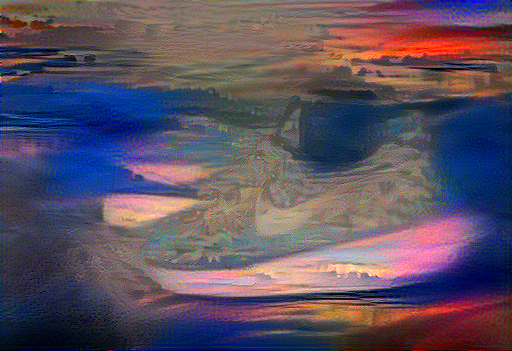

Train step: 1000
Total time :  9316.7


In [27]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        training_step(image)
        print('=', end ='')
    display.clear_output(wait=True)
    display.display(tensor_image(image))
    print('Train step: {}'.format(step))
    
end = time.time()
print('Total time : {: .1f}'.format(end-start))
    

In [ ]:
# I did not apply total variation loss.

In [ ]:
# reference : https://www.tensorflow.org/tutorials/generative/style_transfer